In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

In [3]:
def setup_dataframes():
    df = pd.read_csv('MM_game_data.csv')
    df = df[df['YEAR'] >= 2013]
    df = df[df['YEAR'] <= 2023]
    np.unique(df['YEAR'])
    games = df.drop(['ROUND'], axis=1)
    
    df = pd.read_csv('cbb.csv')
    df = df[df['SEED'] > 0]
    df = df[df['YEAR'] <= 2021]
    teams = df.drop(['CONF', 'POSTSEASON', 'SEED'], axis=1)
    
    rv = np.floor(np.random.rand(len(games))*2)
    
    return (games,teams,rv)

In [4]:
def get_team_data(team, year):
    all_years = teams.loc[teams['TEAM'] == team]
    specific_year = all_years.loc[all_years['YEAR'] == year]
    return specific_year

In [5]:
def assemble_game_data():
    game_data = np.zeros(shape=(len(games), 38))
    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR']).drop(['TEAM', 'YEAR'], axis=1)
        if rv[i] == 0:
            game_data[i] = np.hstack([wdata, ldata])
        else:
            game_data[i] = np.hstack([ldata, wdata])
    return game_data

In [6]:
def assemble_response_data():
    score_diff = []
    for i in range(0,len(games)):
        if rv[i] == 0:
            score_diff.append(games.iloc[i]['WSCORE'] - games.iloc[i]['LSCORE'])
        else:
            score_diff.append(games.iloc[i]['LSCORE'] - games.iloc[i]['WSCORE'])
    return score_diff

In [7]:
def get_invalid_team_names():
    wrong_names = []

    for i in range(0,len(games)):
        wdata = get_team_data(games.iloc[i]['WTEAM'], games.iloc[i]['YEAR'])
        if wdata.empty:
            wrong_names.append(games.iloc[i]['WTEAM'])
        ldata = get_team_data(games.iloc[i]['LTEAM'], games.iloc[i]['YEAR'])
        if ldata.empty:
            wrong_names.append(games.iloc[i]['LTEAM'])
    return np.unique(wrong_names)

In [8]:
(games,teams,rv) = setup_dataframes()

In [9]:
game_data = assemble_game_data()
score_data = assemble_response_data()
X_train, X_test, y_train, y_test = train_test_split(game_data, score_data, test_size=0.2, random_state=1)

0.42390977791397155

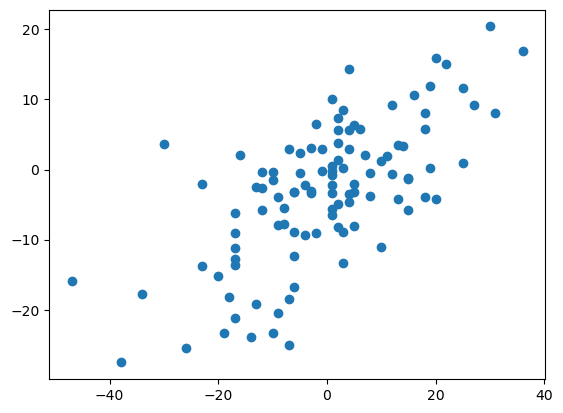

In [10]:
regr = MLPRegressor(random_state=1).fit(X_train, y_train)

pred = regr.predict(X_test)
plt.scatter(y_test, pred)
regr.score(X_test, y_test)

In [49]:
win_data = (np.sign(score_data) + 1)/2

In [47]:
layers = [tf.keras.Input(shape=(None,38)), Dense(1000, activation="relu"), Dropout(0.1), Dense(500, activation="relu"), Dropout(0.2), Dense(250, activation="relu"), Dense(2, activation="softmax")]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, None, 1000)        39000     
                                                                 
 dropout_3 (Dropout)         (None, None, 1000)        0         
                                                                 
 dense_37 (Dense)            (None, None, 500)         500500    
                                                                 
 dropout_4 (Dropout)         (None, None, 500)         0         
                                                                 
 dense_38 (Dense)            (None, None, 250)         125250    
                                                                 
 dense_39 (Dense)            (None, None, 2)           502       
                                                                 
Total params: 665252 (2.54 MB)
Trainable params: 66525

In [50]:
n_epochs = 20
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(game_data, win_data, epochs=n_epochs)

Epoch 1/20
17/17 [==============================] - 4s 25ms/step - loss: 0.6428 - accuracy: 0.6449
Epoch 2/20
17/17 [==============================] - 0s 24ms/step - loss: 0.7021 - accuracy: 0.6374
Epoch 3/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5879 - accuracy: 0.6748
Epoch 4/20
17/17 [==============================] - 0s 23ms/step - loss: 0.5901 - accuracy: 0.6766
Epoch 5/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5228 - accuracy: 0.7364
Epoch 6/20
17/17 [==============================] - 0s 23ms/step - loss: 0.5565 - accuracy: 0.7364
Epoch 7/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5577 - accuracy: 0.7084
Epoch 8/20
17/17 [==============================] - 0s 23ms/step - loss: 0.5780 - accuracy: 0.7103
Epoch 9/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5453 - accuracy: 0.7047
Epoch 10/20
17/17 [==============================] - 0s 24ms/step - loss: 0.5405 - accuracy: 0.7159
Epoch 11/

In [71]:
pred = model(game_data)
#confusion_matrix(win_data, pred)
confusion_matrix(win_data, np.round(pred[:,1]))

array([[142, 110],
       [ 22, 261]], dtype=int64)

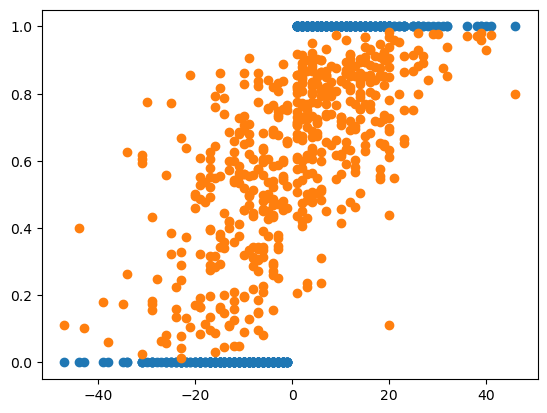

In [73]:
plt.scatter(score_data, win_data)
plt.scatter(score_data, pred[:,1])

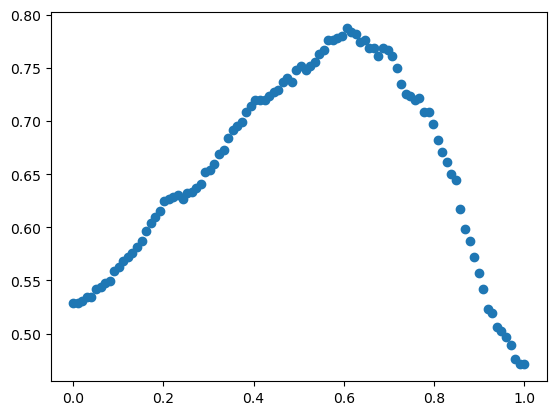

In [81]:
cutoffs = np.linspace(0, 1, 100)
accuracies = []
for cutoff in cutoffs:
    pred1 = np.ceil(pred[:,1] - cutoff)
    accuracies.append(accuracy_score(win_data, pred1))
    
plt.scatter(cutoffs, accuracies)